In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import os
from collections import Counter
tf.compat.v1.set_random_seed(0)
from tensorflow import keras as keras
np.random.seed(0)
import itertools

# import keras_tuner as kt
# from keras_tuner import HyperParameters
from keras.utils import image_dataset_from_directory, to_categorical
from keras.layers.experimental.preprocessing import Rescaling
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing import image
from keras.models import load_model
from keras.regularizers import l2
from keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip new-plant-diseases-dataset.zip -d new-plant-diseases-dataset/

In [ ]:
train_gen = image_dataset_from_directory(directory="new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(256, 256))
valid_gen = image_dataset_from_directory(directory="new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(256, 256))
classes_names = train_gen.class_names

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
valid_gen  = valid_gen.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [ ]:
# Step 1: Import Necessary Libraries (done above)
# Step 2: Define the Identity Block

def identity_block(x, filters, kernel_size=3, l2_reg=0.01):
    fx = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    fx = BatchNormalization()(fx)
    fx = ReLU()(fx)

    fx = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(x)
    fx = BatchNormalization()(fx)

    x = Add()([x, fx])
    x = ReLU()(x)
    return x

# Step3: Define the Convolutional Block
def convolutional_block(x, filters, kernel_size=3, stride=2, l2_reg=0.01):
    shortcut = x

    # First component of main path with stride
    fx = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(x)
    fx = BatchNormalization()(fx)
    fx = ReLU()(fx)

    # Second component of main path without changing the size
    fx = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(l2_reg))(fx)
    fx = BatchNormalization()(fx)

    # Shortcut path to match the dimensionality if needed
    shortcut_channels = shortcut.shape[-1]
    if stride != 1 or shortcut_channels != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_regularizer=l2(l2_reg))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Final step: Add shortcut value to the main path, and pass it through a ReLU activation
    x = Add()([fx, shortcut])
    x = ReLU()(x)
    return x


# Step4: Build the ResNet-18 Model
def ResNet18(input_shape=(224, 224, 3), classes=1000, hp=None):
    if hp is None:
        hp = HyperParameters()

    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG')
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    num_filters = 64

    for block in range(2):
        x = identity_block(x, num_filters, l2_reg=l2_reg)

    # Subsequent sets of blocks - doubles the number of filters after each convolutional block
    for block_set in range(3):
        num_filters *= 2  # Double the number of filters at each set
        x = convolutional_block(x, num_filters, l2_reg=l2_reg)  # Apply convolutional block with stride=2 to reduce dimensions
        for block in range(1):  # Apply identity blocks that preserve dimensions
            x = identity_block(x, num_filters, l2_reg=l2_reg)

    x = GlobalAveragePooling2D()(x)

    # Adding a Dropout layer before the final Dense layer
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model inside the build function
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
def build_model(hp):
    return ResNet18(input_shape=(256, 256, 3), classes=38, hp=hp)

# Create a tuner. You can specify the objective, the number of trials, and the directory to save the models and logs
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='random_search_2',
    project_name='plant_disease_classification_2'
)

# Display search space summary
tuner.search_space_summary()

# Perform the hyperparameter search. The arguments for the search method are the same as those for model.fit()
tuner.search(train_gen,
             validation_data=valid_gen,
             epochs=5,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 3 Complete [00h 12m 48s]
val_accuracy: 0.857671320438385

Best val_accuracy So Far: 0.8923856019973755
Total elapsed time: 00h 38m 51s
Best learning rate: 0.00010610861754866582


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print all the best hyperparameters
print("Best Hyperparameters Found:")
for hyperparam, value in best_hps.values.items():
    print(f"{hyperparam}: {value}")

Best Hyperparameters Found:
l2_reg: 0.00010807693310770887
dropout_rate: 0.30000000000000004
learning_rate: 0.00010610861754866582


In [ ]:
# Step6: Train the Model
# Build the model with the best hyperparameters and train it on the data for 10 epochs
model = build_model(best_hps)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/10
2197/2197 [==============================] - 144s 62ms/step - loss: 1.1351 - accuracy: 0.7595 - val_loss: 0.7984 - val_accuracy: 0.8509 - lr: 1.0611e-04
Epoch 2/10
2197/2197 [==============================] - 137s 62ms/step - loss: 0.6113 - accuracy: 0.9101 - val_loss: 0.9765 - val_accuracy: 0.8080 - lr: 1.0611e-04
Epoch 3/10
2197/2197 [==============================] - 138s 63ms/step - loss: 0.4987 - accuracy: 0.9407 - val_loss: 0.6356 - val_accuracy: 0.8920 - lr: 1.0611e-04
Epoch 4/10
2197/2197 [==============================] - 138s 63ms/step - loss: 0.4322 - accuracy: 0.9555 - val_loss: 0.6791 - val_accuracy: 0.8758 - lr: 1.0611e-04
Epoch 5/10
2197/2197 [==============================] - 133s 61ms/step - loss: 0.3819 - accuracy: 0.9645 - val_loss: 0.8366 - val_accuracy: 0.8405 - lr: 1.0611e-04
Epoch 6/10
2197/2197 [==============================] - 137s 63ms/step - loss: 0.3446 - accuracy: 0.9701 - val_loss: 0.4790 - val_accuracy: 0.9273 - lr: 1.0611e-04
Epoch 7/10
2197/

In [ ]:
# Save Model
model.save('plant_disease_resnet18_model_epoch_10_v2.h5')

In [ ]:
# Save history
import pickle

with open('model_epoch_10_v2_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)
print("History object saved.")

History object saved.


In [ ]:
from keras.models import load_model
import pickle

# Load the model
model = load_model('plant_disease_resnet18_model_epoch_10_v2.h5')
print("Model loaded successfully.")

# Load the history
with open('model_epoch_10_v2_history.pkl', 'rb') as file:
    history = pickle.load(file)
print("History object loaded successfully.")

In [ ]:
# Step7: Evaluate the Model

# Additional Step: Print out the losses and accuracies for training and validation
train_loss = history['loss']
train_accuracy = history['accuracy']
val_loss = history['val_loss']
val_accuracy = history['val_accuracy']

# After training
for epoch in range(len(history['accuracy'])):
    print(f"Epoch {epoch+1}/{len(history['accuracy'])}")
    print(f"Training loss: {history['loss'][epoch]}")
    print(f"Training accuracy: {history['accuracy'][epoch]}")
    print(f"Validation loss: {history['val_loss'][epoch]}")
    print(f"Validation accuracy: {history['val_accuracy'][epoch]}")

NameError: ignored

In [ ]:
# Plotting for Phase 1: Hand-made ResNet-18 Model Performance

class TrainingHistoryPlotter:
    def __init__(self, history):
        """
        Initialize the plotter with training history.
        :param history: A history object from the training session.
        """
        self.history = history

    def plot_accuracy(self):
        """
        Plots the training and validation accuracy.
        """
        plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()  # Adjust the layout
        plt.show()

    def plot_loss(self):
        """
        Plots the training and validation loss.
        """
        plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()  # Adjust the layout
        plt.show()

    # If learning rate was recorded, add a method to plot it
    def plot_learning_rate(self):
        """
        Plots the learning rate over epochs (if it's part of the history).
        """
        if 'lr' in self.history:
            plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
            plt.plot(self.history['lr'], label='Learning Rate')
            plt.title('Learning Rate over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
            plt.tight_layout()  # Adjust the layout
            plt.show()
        else:
            print("Learning rate not found in history.")


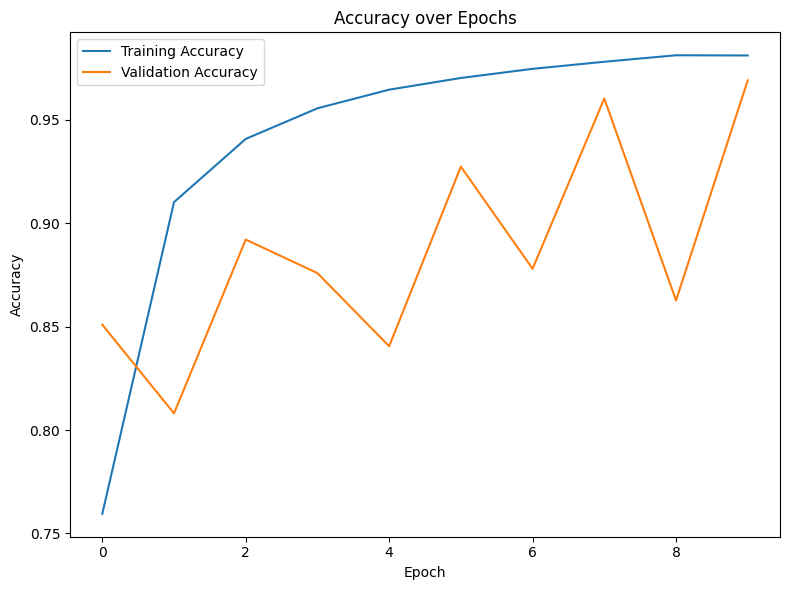

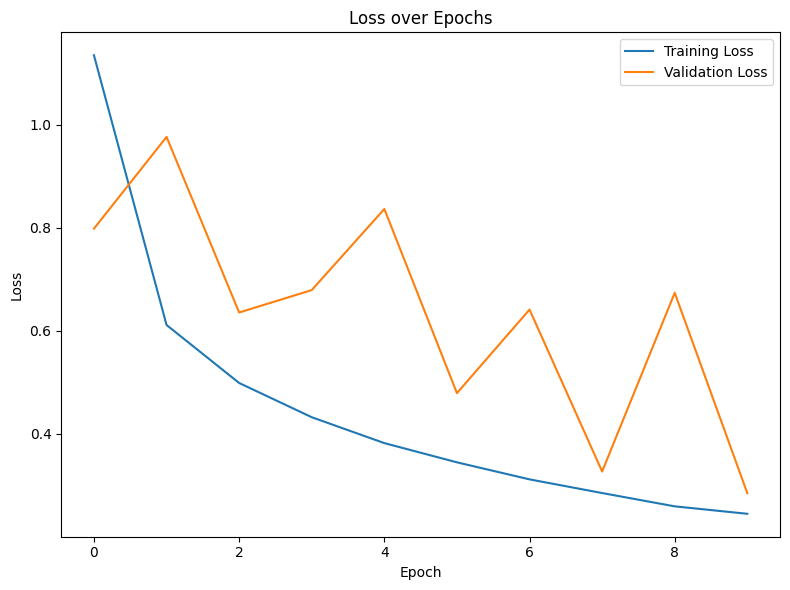

In [ ]:
# Visualize Training and Validation Loss and Accuracy

# with open('model_history.pkl', 'rb') as file:
#     history = pickle.load(file)

plotter = TrainingHistoryPlotter(history)
plotter.plot_accuracy()
print()
plotter.plot_loss()

1/1 [==============================] - 0s 81ms/step


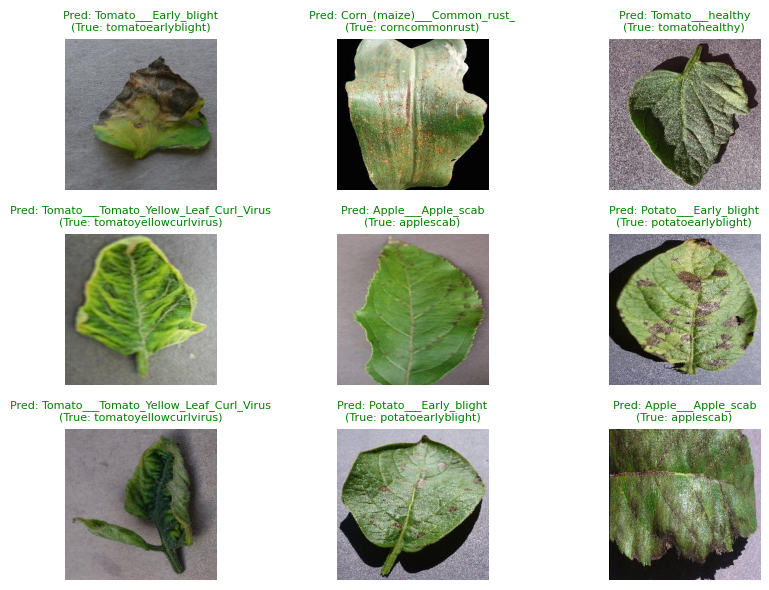

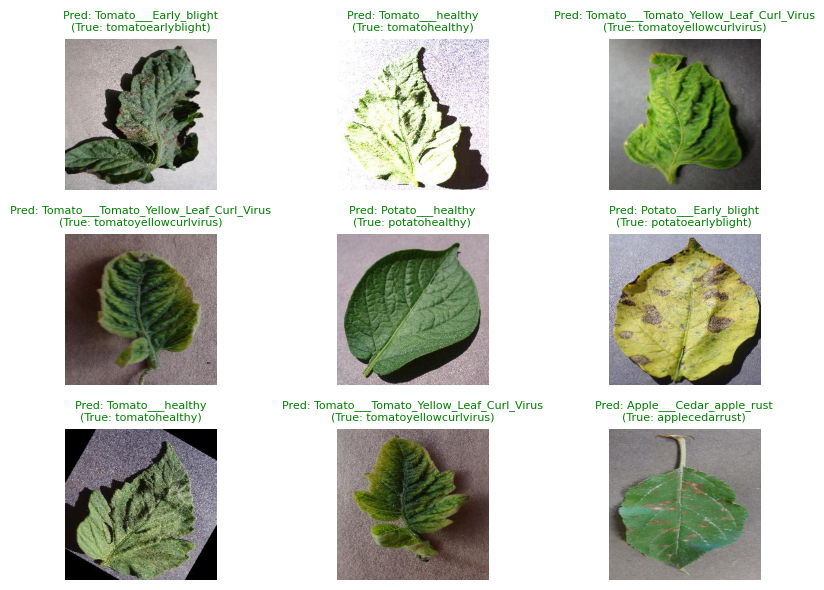

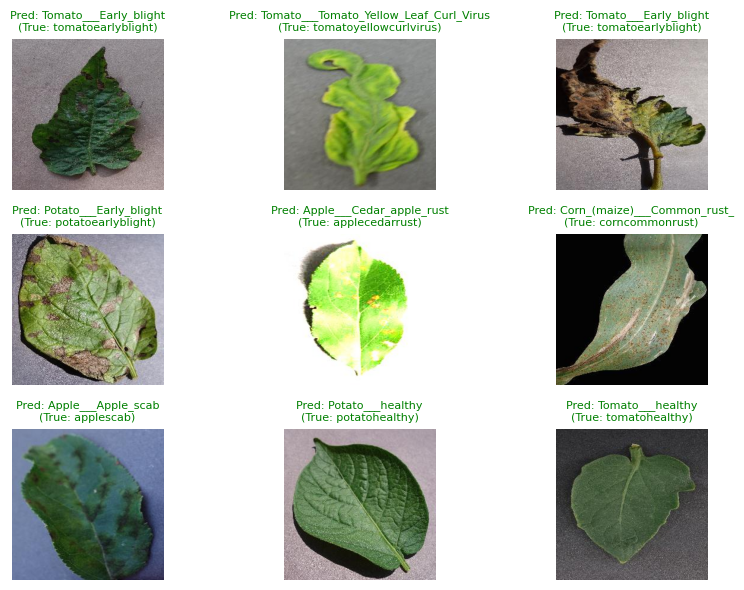

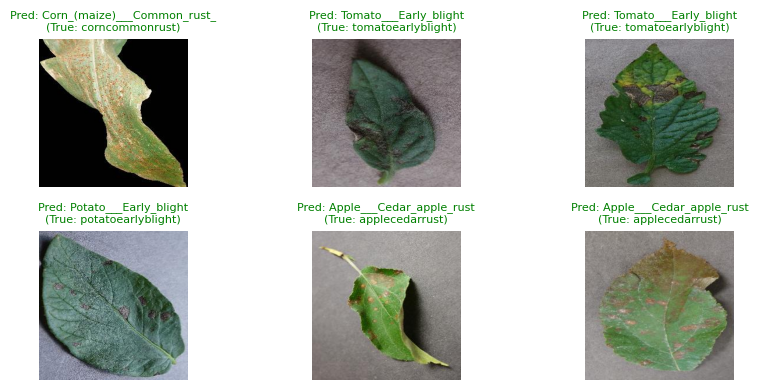




Success Rate: 33 / 33


In [ ]:
# Visualize Prediction Results from test folder

# Load your trained model
#model = load_model('plant_disease_resnet18_model.h5')

# Directory containing test images
test_images_dir = 'new-plant-diseases-dataset/test/test/'

# List of class names in the order they were during training (classes_names)

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(256, 256)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale the image
    return img_array, img

# Helper function to check if the prediction is correct based on the filename
def normalizeFileName(filename, predicted_class):
    # Normalize strings for comparison: lowercase and replace underscores with spaces
    normalized_filename = filename.lower().replace('.jpg', '').replace('.jpeg', '')
    normalized_filename = normalized_filename[:-1]
    normalized_predicted_class = predicted_class.lower().replace('_', ' ').replace(' ','')
    return normalized_filename, normalized_predicted_class

def isCorrect(str1, str2):
    it = iter(str2)
    return all(c in it for c in str1)

# Function to plot images and their predicted classes in a 3x3 grid
def plot_predictions(images, filenames, predictions, max_images_per_grid=9):
    """Plots images with their predictions in multiple 3x3 grids, with correct predictions in green and incorrect in red."""
    num_images = len(images)
    num_grids = math.ceil(num_images / max_images_per_grid)
    successCount = 0

    for grid_num in range(num_grids):
        start_idx = grid_num * max_images_per_grid
        end_idx = start_idx + max_images_per_grid
        subset_images = images[start_idx:end_idx]
        subset_filenames = filenames[start_idx:end_idx]
        subset_predictions = predictions[start_idx:end_idx]

        num_cols = 3
        num_rows = math.ceil(len(subset_images) / num_cols)

        plt.figure(figsize=(3 * num_cols, 2 * num_rows))
        for i, (img, filename, pred) in enumerate(zip(subset_images, subset_filenames, subset_predictions)):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(img)
            normalized_filename, normalized_predicted_class = normalizeFileName(filename, pred)
            correct = isCorrect(normalized_filename, normalized_predicted_class)
            if correct:
                successCount += 1

            #print(f"filename: {normalized_filename}, pred: {normalized_predicted_class}")
            title_color = 'green' if correct else 'red'
            plt.title(f"Pred: {pred}\n(True: {normalized_filename})", color=title_color, fontsize=8)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        print('\n\n')

    return successCount

# Load and predict images, then collect their actual data and predictions
test_images = []
test_preds = []
fileNames = []
successCount = 0

for img_name in os.listdir(test_images_dir):
    if img_name.lower().endswith('.jpg') or img_name.lower().endswith('.jpeg'):
        fileNames.append(img_name)
        img_path = os.path.join(test_images_dir, img_name)
        img_array, img = load_and_preprocess_image(img_path)
        pred = model.predict(img_array)
        #print("img_array: ", img_array.shape)
        # print('pred: ', pred)
        pred_class = classes_names[np.argmax(pred)]
        test_images.append(img)
        test_preds.append(pred_class)

# Now use the plotting function to display the images with predictions

#print(fileNames)
successCount = plot_predictions(test_images, fileNames, test_preds)
print(f"Success Rate: {successCount} / {len(fileNames)}")

1/1 [==============================] - 0s 79ms/step


ValueError: ignored

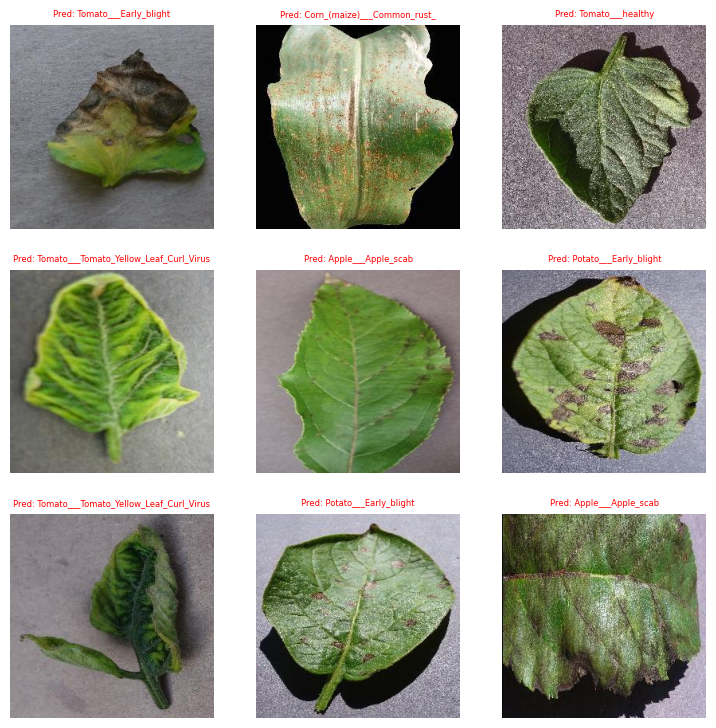

In [ ]:
# Visualize Prediction Results from test folder

# Load your trained model
#model = load_model('plant_disease_resnet18_model.h5')

# Directory containing test images
test_images_dir = 'new-plant-diseases-dataset/test/test/'

# List of class names in the order they were during training (classes_names)

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(256, 256)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Rescale the image
    return img_array, img

# Helper function to check if the prediction is correct based on the filename
def normalizeFileName(filename, predicted_class):
    # Normalize strings for comparison: lowercase and replace underscores with spaces
    normalized_filename = filename.lower().replace('.jpg', '').replace('.jpeg', '')
    normalized_filename = normalized_filename[:-1]
    normalized_predicted_class = predicted_class.lower().replace('_', ' ').replace(' ','')
    return normalized_filename, normalized_predicted_class

def isCorrect(str1, str2):
    it = iter(str2)
    return all(c in it for c in str1)

# Function to plot images and their predicted classes in a 3x3 grid
def plot_predictions(images, filenames, predictions):
    num_images = len(images)
    num_cols = 3
    num_rows = math.ceil(num_images / num_cols)

    plt.figure(figsize=(9,9))

    for i, (img, filename, pred) in enumerate(zip(images, filenames, predictions)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        correct = isCorrect(pred, filename)
        title_color = 'green' if correct else 'red'
        plt.title(f"Pred: {pred}", color=title_color, fontsize=6)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load and predict images, then collect their actual data and predictions
test_images = []
test_preds = []
fileNames = []
successCount = 0

for img_name in os.listdir(test_images_dir):
    if img_name.lower().endswith('.jpg') or img_name.lower().endswith('.jpeg'):
        fileNames.append(img_name)
        img_path = os.path.join(test_images_dir, img_name)
        img_array, img = load_and_preprocess_image(img_path)
        pred = model.predict(img_array)

        pred_class = classes_names[np.argmax(pred)]
        test_images.append(img)
        test_preds.append(pred_class)

plot_predictions(test_images, fileNames, test_preds)

[0.8508991599082947, 0.8080468773841858, 0.892044186592102, 0.8758251667022705, 0.8404848575592041, 0.9272706508636475, 0.8779308199882507, 0.9602208137512207, 0.8626223802566528, 0.9689847230911255]
95% Confidence interval for the accuracy: [0.86, 0.92]


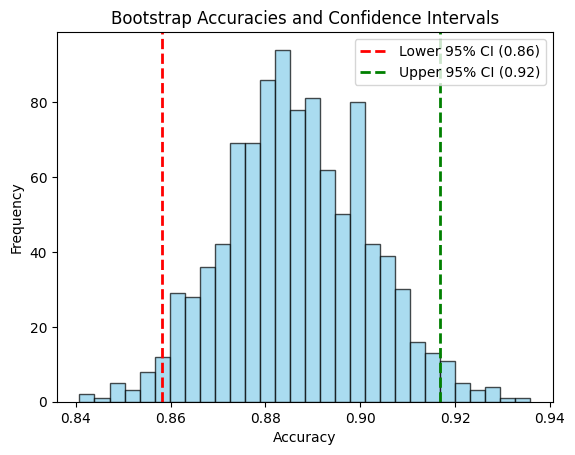

In [ ]:
# Confidence Intervals
accuracies = history['val_accuracy']

print(accuracies)

n_boots = 1000
bootstrap_accuracies = []

# Perform bootstrap sampling
for _ in range(n_boots):
    # Randomly sample from the accuracies with replacement
    boot = resample(accuracies)
    # Calculate the mean of the bootstrapped samples
    boot_mean = np.mean(boot)
    bootstrap_accuracies.append(boot_mean)

# Calculate the percentiles for the 95% confidence interval
lower_percentile = 2.5
upper_percentile = 97.5
confidence_lower = np.percentile(bootstrap_accuracies, lower_percentile)
confidence_upper = np.percentile(bootstrap_accuracies, upper_percentile)

print(f"95% Confidence interval for the accuracy: [{confidence_lower:.2f}, {confidence_upper:.2f}]")

# Assuming bootstrap_accuracies is already populated from the previous step
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=confidence_lower, color='red', linestyle='dashed', linewidth=2, label=f'Lower 95% CI ({confidence_lower:.2f})')
plt.axvline(x=confidence_upper, color='green', linestyle='dashed', linewidth=2, label=f'Upper 95% CI ({confidence_upper:.2f})')
plt.title('Bootstrap Accuracies and Confidence Intervals')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

1/1 [==============================] - 0s 34ms/step


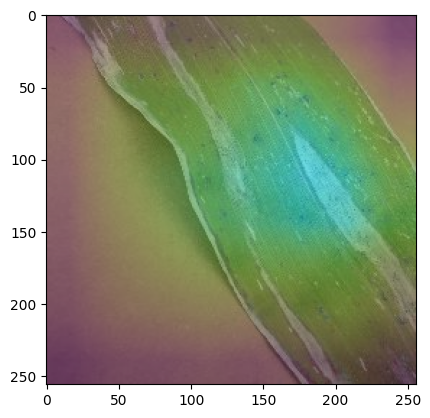

In [ ]:
# Feature Visualization (Grad-CAM)

layer_name = 'conv2d_119'

# Load and preprocess an image
img_path = '/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___Northern_Leaf_Blight/0118e276-ee7b-4fed-961d-057590ae9f7f___RS_NLB 4666 copy 2.jpg'
img_array, img = load_and_preprocess_image(img_path)
pred = model.predict(img_array)
pred_class = classes_names[np.argmax(pred)]

# Instantiate a GradCAM object
gradcam = GradCAM(model, 0, layer_name)

# Compute heatmap
heatmap = gradcam.compute_heatmap(img_array)

# Use OpenCV to load the original image
orig = cv2.imread(img_path)

# Resize heatmap to the size of the original image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))

# Apply the heatmap to the original image
(heatmap, output) = gradcam.overlay_heatmap(heatmap, orig, alpha=0.5)

# Display results
plt.imshow(output)
plt.show()

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Collect all the true labels and predictions
true_labels = []
predictions = []

for images, labels in valid_gen:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    # If labels are already in integer form, no need for argmax
    if labels.ndim > 1:
        true = np.argmax(labels, axis=1)
    else:
        true = labels

    true_labels.extend(true)
    predictions.extend(preds)


# Compute confusion matrix
conf_mat = confusion_matrix(true_labels, predictions)
fig, ax = plt.subplots(figsize=(10,10))  # Adjust size as needed
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import to_categorical
from itertools import cycle
import matplotlib.pyplot as plt


true_labels = []
pred_probs = []

for images, labels in valid_gen:
    probs = model.predict(images)
    if labels.ndim > 1:
        true = np.argmax(labels, axis=1)
    else:
        true = labels

    true_labels.extend(true)
    pred_probs.extend(probs)

In [ ]:
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

true_labels_bin = label_binarize(true_labels, classes=range(len(classes_names)))

# Calculate ROC-AUC for each class
roc_auc_scores = {}
for i, class_name in enumerate(classes_names):
    # Ensure we're indexing properly
    class_true_labels = true_labels_bin[:, i]
    class_pred_probs = pred_probs[:, i]

    # Calculate ROC-AUC for the current class
    roc_auc_scores[class_name] = roc_auc_score(class_true_labels, class_pred_probs)

# Print ROC-AUC scores for each class
for class_name, roc_auc in roc_auc_scores.items():
    print(f"{class_name}: {roc_auc:.3f}")

# You can also calculate the micro-average and macro-average ROC-AUC across all classes
micro_avg_roc_auc = roc_auc_score(true_labels_bin, pred_probs, average="micro")
macro_avg_roc_auc = roc_auc_score(true_labels_bin, pred_probs, average="macro")

print(f"Micro-average ROC-AUC: {micro_avg_roc_auc:.3f}")
print(f"Macro-average ROC-AUC: {macro_avg_roc_auc:.3f}")

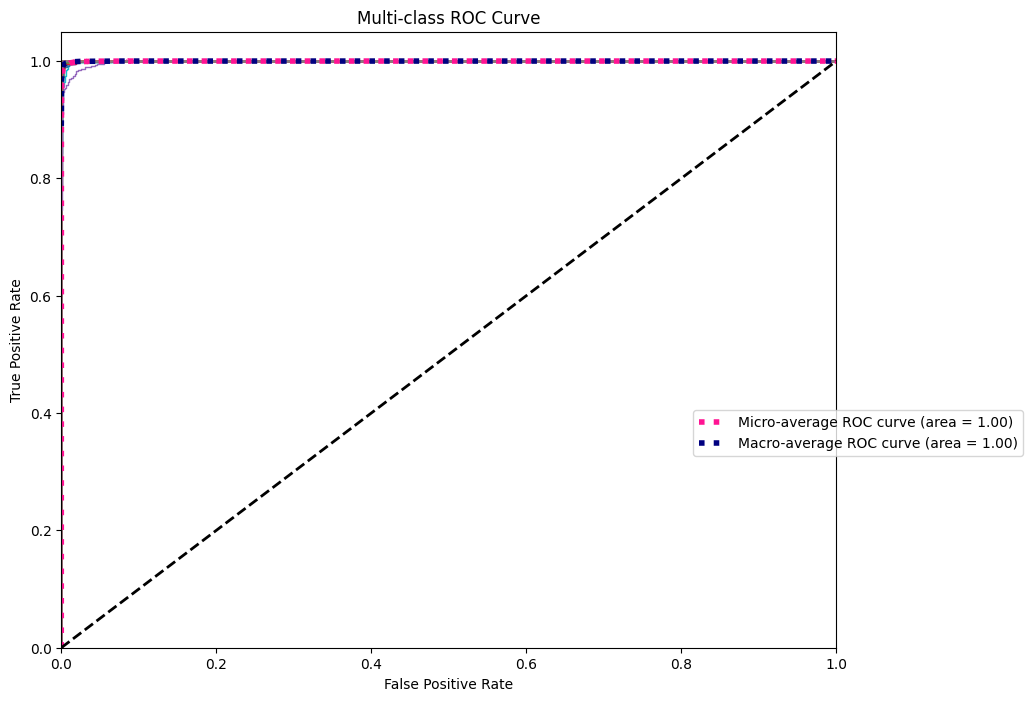

In [ ]:
# Assuming true_labels_bin and pred_probs are already defined and are numpy arrays
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and ROC area for each class
for i in range(len(classes_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
#print(fpr)
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes_names))]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(classes_names)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(10, 8))
# Plot each individual ROC curve
for i in range(len(classes_names)):
    plt.plot(fpr[i], tpr[i], lw=1)

# Plot micro and macro average ROC curves
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')

# Place a legend to the right of the plot
plt.legend(loc="lower right", bbox_to_anchor=(1.25, 0.3))

plt.show()


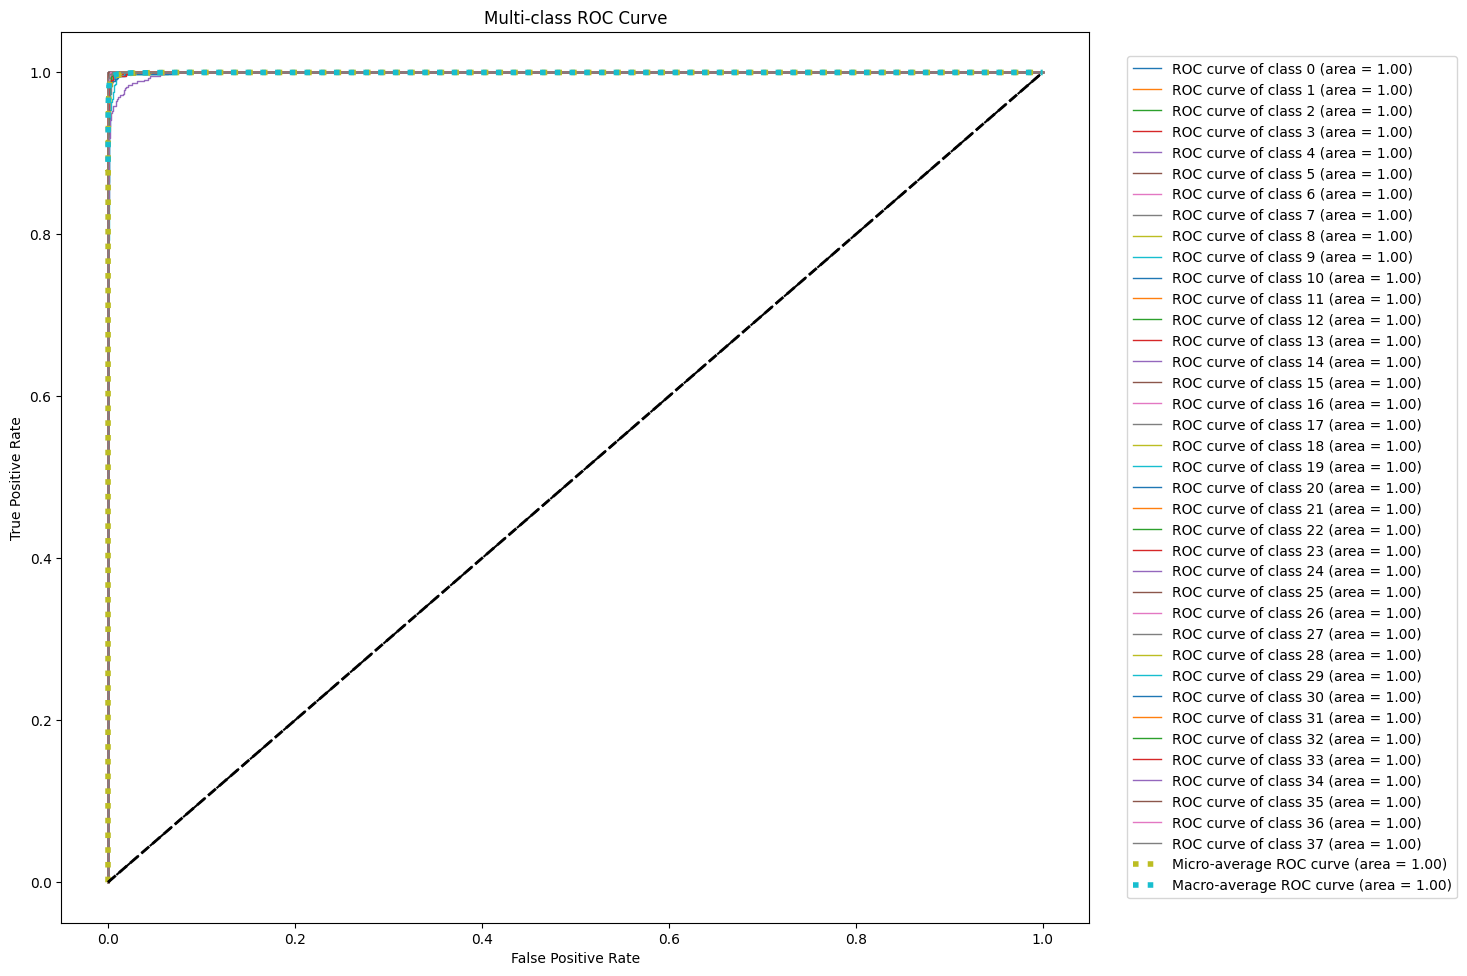

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2,0.5]})

# Plot all the individual ROC curves
for i in range(len(classes_names)):
    ax1.plot(fpr[i], tpr[i], lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plot the micro and macro-average ROC curves
ax1.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), linestyle=':', linewidth=4)
ax1.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]), linestyle=':', linewidth=4)

# Plot the random chance line
ax1.plot([0, 1], [0, 1], 'k--', lw=2)

handles, labels = ax1.get_legend_handles_labels()
ax2.legend(handles, labels, loc='center')
ax2.axis('off')  # Hide the axis

# Set common titles, labels, etc.
ax1.set_title('Multi-class ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot([0, 1], [0, 1], 'k--')  # Add a diagonal line for reference

# Adjust the layout so that the plots are not overlapping
plt.tight_layout()

# Show the combined plot
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

model = load_model('/content/plant_disease_resnet18_model_epoch_10_v2.h5')

# Capture the summary output
summary_str_list = []
model.summary(print_fn=lambda x: summary_str_list.append(x))
summary_str = "\n".join(summary_str_list)

# Use matplotlib to display the summary as an image
fig = plt.figure(figsize=(8, 6))
plt.text(0.5, 0.5, summary_str, transform=fig.transFigure, size=12, ha="center", va="center")
plt.axis('off')
plt.show()


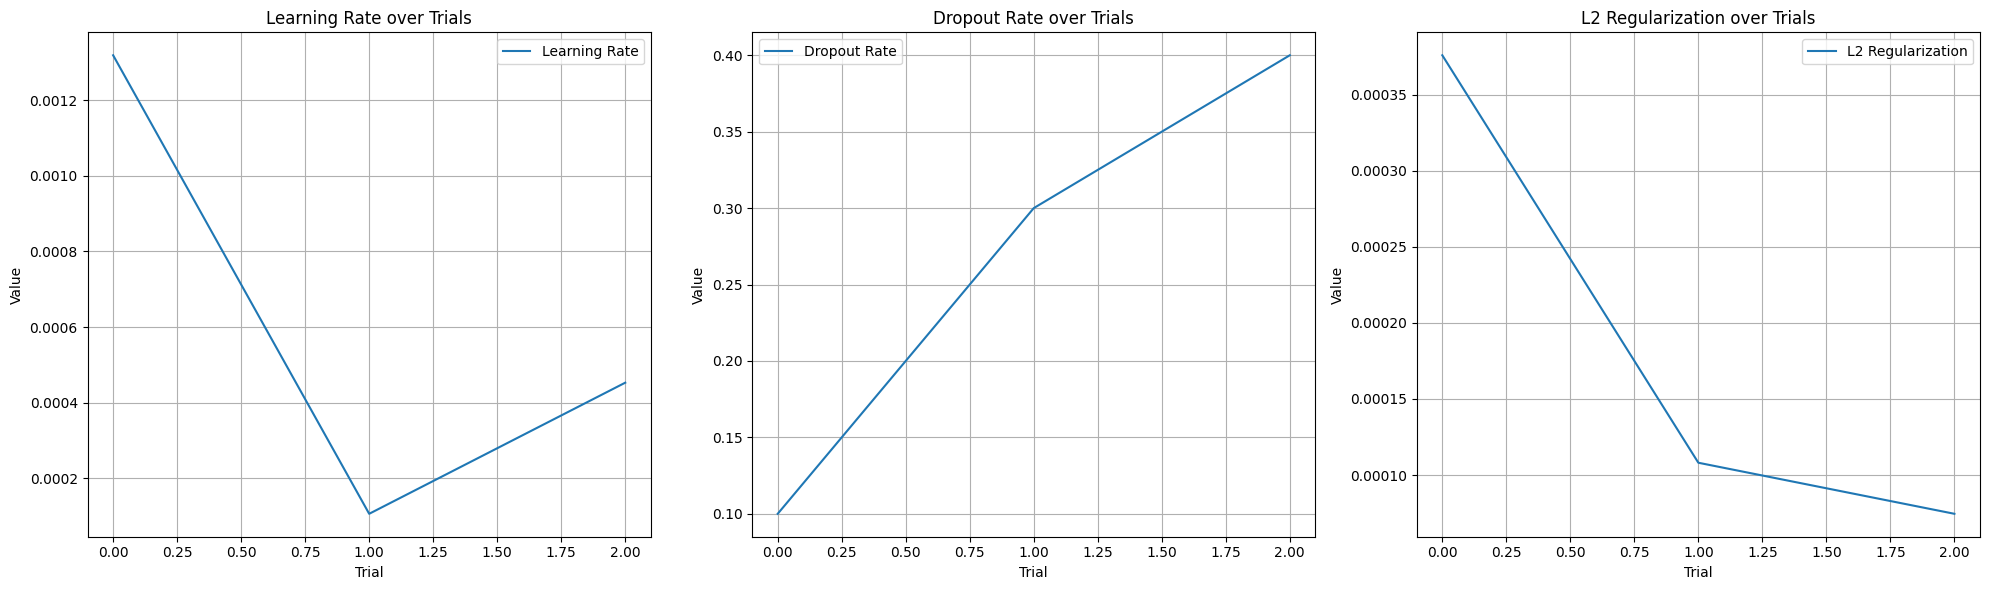

In [ ]:
import json
import matplotlib.pyplot as plt

# Function to load the trial data from JSON files
def load_trial_data(file_paths):
    trial_data = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
            trial_data.append(data)
    return trial_data

# Assuming the JSON files are saved in the following paths
file_paths = ['trial0.json', 'trial2.json', 'trial3.json']

# Load the trial data
data = load_trial_data(file_paths)
#print(data)

# Plot the change of hyperparameters over time
plt.figure(figsize=(20, 6))

# Assuming the JSON files have a structure that includes 'hyperparameters' and their 'values'
# Extract hyperparameter values for plotting
learning_rates = [trial['hyperparameters']['values']['learning_rate'] for trial in data]
dropouts = [trial['hyperparameters']['values']['dropout_rate'] for trial in data]
l2_regs = [trial['hyperparameters']['values']['l2_reg'] for trial in data]

# Plotting each hyperparameter change
plt.subplot(1, 3, 1)
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Learning Rate over Trials')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(dropouts, label='Dropout Rate')
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Dropout Rate over Trials')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(l2_regs, label='L2 Regularization')
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('L2 Regularization over Trials')
plt.grid()
plt.legend()

plt.tight_layout()

plt.show()